In [1]:
import pandas as pd 
import numpy as np
from utils import *
import time
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from stock_assess import *
%matplotlib inline

In [3]:
# df = pd.read_csv('./data/saved_data3.csv')
# price = df[['day','stock','close']]
# price.columns = ['date','asset','adjclose']

In [10]:
# df = pd.read_csv('./data/CONTEST_DATA_IN_SAMPLE_FULL.csv')
# price = df[['date','asset','close']]
# price.columns = ['date','asset','adjclose']
df = pd.read_csv('./data/saved_data3.csv').drop_duplicates()
price = df[['day','stock','close']]
price.columns = ['date','asset','adjclose']

df.columns = ['time','stkcd','open','high','low','close','volume']

close_df = pd.DataFrame()
high_df = pd.DataFrame()
low_df = pd.DataFrame()
volume_df = pd.DataFrame()
for sub_df in df.groupby('stkcd'):
    close_df[sub_df[0]] = sub_df[1].reset_index().close
    high_df[sub_df[0]] = sub_df[1].reset_index().high
    low_df[sub_df[0]] = sub_df[1].reset_index().low
    volume_df[sub_df[0]] = sub_df[1].reset_index().volume
highs = high_df.values
lows = low_df.values
closes = close_df.values
volumes = volume_df.values

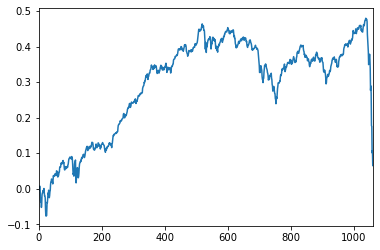

In [29]:
close_df.pct_change().mean(axis=1).cumsum().plot()

In [11]:
horizon = 1
rts = close_df.pct_change(horizon).shift(-horizon-1).fillna(0).values # returns

In [12]:
avgs = np.empty((0,closes.shape[1]))
moms = np.empty((0,closes.shape[1]))
vols = np.empty((0,closes.shape[1]))
max52s = np.empty((0,closes.shape[1]))
min52s = np.empty((0,closes.shape[1]))
ccis = np.empty((0,closes.shape[1]))
Ks = np.empty((0,closes.shape[1]))
Ds = np.empty((0,closes.shape[1]))
Js = np.empty((0,closes.shape[1]))
rsis = np.empty((0,closes.shape[1]))
trixs = np.empty((0,closes.shape[1]))
willrs = np.empty((0,closes.shape[1]))
macds = np.empty((0,closes.shape[1]))
natrs = np.empty((0,closes.shape[1]))
mfis = np.empty((0,closes.shape[1]))
start = time.time()
for i in range(1,len(closes)+1):
    c = closes[:i]
    h = highs[:i]
    l = lows[:i]
    v = volumes[:i]
    avg=get_avg(c,3)
    mom=get_mom(c,5)
    vol=get_vol(c,5)
    max52=get_52weekhigh(c)
    min52=get_52weeklow(c)
    cci = get_cci(h,l,c)
    K,D,J = get_kdj(h,l,c)
    rsi = get_rsi(c)
    trix = get_trix(c)
    willr = get_willr(h,l,c)
    macd = get_macd(c)
    natr = get_natr(h,l,c)
    mfi = get_mfi(c,h,l,v)

    avgs=np.vstack([avgs,avg])
    moms=np.vstack([moms,mom])
    vols=np.vstack([vols,vol])
    max52s=np.vstack([max52s,max52])
    min52s=np.vstack([min52s,min52])
    ccis=np.vstack([ccis,cci])
    Ks=np.vstack([Ks,K])
    Ds=np.vstack([Ds,D])
    Js=np.vstack([Js,J])
    rsis=np.vstack([rsis,rsi])
    trixs=np.vstack([trixs,trix])
    willrs=np.vstack([willrs,willr])
    macds=np.vstack([macds,macd])
    natrs=np.vstack([natrs,natr])
    mfis=np.vstack([mfis,mfi])
    if i%100 == 0:
        print(i)
endtime = time.time()
# print((start-endtime)*1000 / 1900)

100
200
300
400
500
600
700
800
900
1000


In [13]:
def get_weights(factors,top_n=10,tail_n=10,reverse=False):
    weights = np.empty((factors.shape))
    for i,daily_factor in enumerate(factors):
        daily_factor = pd.Series(daily_factor)
        head = daily_factor.nlargest(top_n).index.tolist()
        tail = daily_factor.nsmallest(tail_n).index.tolist()
        weight = np.zeros(factors.shape[1])
        weight[head] = 1 / len(head)
        weight[tail] = -1 / len(tail)
        if reverse:
            weight = -1 * weight
        weights[i] = weight
    return weights

def get_pnl_by_factors(factors,price,top_n=10,tail_n=10,reverse=True):
    factor_w = get_weights(factors,top_n=top_n,tail_n=tail_n,reverse=reverse)
    factor_weight = pd.DataFrame(factor_w).stack().reset_index()
    factor_weight.columns=['date','asset','weight']
    factor_weight['asset'] += 1000
    result=backtest(factor_weight,price,bench_code='000905.SH')
    return result['Performance']['PtfRet'].values

In [14]:
factor_pnl = pd.DataFrame()
factor_pnl['avg'] = get_pnl_by_factors(avgs,price)
factor_pnl['mom'] = get_pnl_by_factors(moms,price)
factor_pnl['vol'] = get_pnl_by_factors(vols,price,reverse=False)
factor_pnl['max52'] = get_pnl_by_factors(max52s,price)
factor_pnl['min52'] = get_pnl_by_factors(min52s,price)
factor_pnl['min52'] = get_pnl_by_factors(min52s,price)
factor_pnl['cci'] = get_pnl_by_factors(ccis,price)
factor_pnl['rsi'] = get_pnl_by_factors(rsis,price)
factor_pnl['K'] = get_pnl_by_factors(Ks,price)
factor_pnl['D'] = get_pnl_by_factors(Ds,price)
factor_pnl['J'] = get_pnl_by_factors(Js,price,reverse=False)
factor_pnl['trix'] = get_pnl_by_factors(trixs,price)
factor_pnl['willr'] = get_pnl_by_factors(willrs,price,reverse=False)
factor_pnl['macd'] = get_pnl_by_factors(macds,price)
factor_pnl['natr'] = get_pnl_by_factors(natrs,price,reverse=False)
factor_pnl['mfi'] = get_pnl_by_factors(mfis,price)

In [16]:
print(factor_pnl.columns.to_list())

['avg', 'mom', 'vol', 'max52', 'min52', 'cci', 'rsi', 'K', 'D', 'J', 'trix', 'willr', 'macd', 'natr', 'mfi']


In [37]:
factor_pnl.mean()

avg      0.002253
mom      0.002645
vol      0.001155
max52    0.001282
min52   -0.000476
cci     -0.000845
K        0.001345
D        0.001492
J        0.000568
trix     0.000868
willr    0.000992
macd     0.000459
natr     0.001520
mfi      0.000407
rsi      0.001395
dtype: float64

In [30]:
factor_pnl.rolling(10).mean().plot()

,avg,mom,vol,max52,min52,cci,rsi,K,D,J,trix,willr,macd,natr,mfi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,0.001148,-0.016337,-0.024159,-0.011326,-0.005863,0.003437,-0.009718,-0.012453,-0.013796,0.009627,-0.026997,-0.022237,-0.026387,-0.033777,-0.017358
1057,0.000420,-0.020439,-0.021753,-0.008229,0.005292,0.002908,-0.007904,-0.014484,-0.012631,0.007310,-0.028331,-0.022839,-0.024546,-0.033851,-0.020978
1058,-0.000713,-0.023235,-0.024663,-0.011228,0.003705,0.002546,-0.011070,-0.015519,-0.014038,0.008898,-0.034386,-0.025269,-0.032913,-0.038678,-0.016740
1059,-0.007232,-0.012486,-0.025370,-0.001482,0.014254,0.000321,-0.006801,-0.016511,-0.017616,0.013459,-0.026785,-0.024739,-0.023615,-0.029100,-0.009744


In [15]:
factor_pnl.corr()

,avg,mom,vol,max52,min52,cci,rsi,K,D,J,trix,willr,macd,natr,mfi
avg,1.000000,-0.003534,0.172144,0.096998,0.031317,-0.039020,0.033444,0.058567,0.058496,-0.086937,-0.033284,0.022088,-0.004137,0.145565,-0.066209
mom,-0.003534,1.000000,0.057961,0.325810,0.211068,-0.007598,0.280784,0.316924,0.284635,0.067427,0.233515,0.335151,0.251904,0.150582,0.196257
vol,0.172144,0.057961,1.000000,0.385871,-0.151072,-0.012145,0.047650,-0.000386,0.033700,0.010111,0.175670,0.049562,0.128378,0.525418,0.030650
max52,0.096998,0.325810,0.385871,1.000000,0.184348,0.023654,0.159339,0.095705,0.133627,-0.028866,0.350449,0.151146,0.272623,0.384143,0.116496
min52,0.031317,0.211068,-0.151072,0.184348,1.000000,-0.019599,0.207145,0.188313,0.174348,-0.060653,0.255043,0.200635,0.193441,-0.167630,-0.008709
cci,-0.039020,-0.007598,-0.012145,0.023654,-0.019599,1.000000,-0.002749,0.030271,0.096279,-0.053051,0.037184,-0.005878,0.084659,-0.125275,0.049074
rsi,0.033444,0.280784,0.047650,0.159339,0.207145,-0.002749,1.000000,0.298804,0.258248,-0.019236,0.222608,0.191488,0.252753,0.059725,0.234108
K,0.058567,0.316924,-0.000386,0.095705,0.188313,0.030271,0.298804,1.000000,0.632258,-0.043299,0.099778,0.376325,0.141399,-0.035869,0.141488
D,0.058496,0.284635,0.033700,0.133627,0.174348,0.096279,0.258248,0.632258,1.000000,-0.155227,0.182039,0.278202,0.214098,0.018900,0.104053
J,-0.086937,0.067427,0.010111,-0.028866,-0.060653,-0.053051,-0.019236,-0.043299,-0.155227,1.000000,-0.089796,0.071614,-0.119576,0.024685,-0.023522


['avg', 'mom', 'vol', 'max52', 'min52', 'cci', 'rsi', 'K', 'D', 'J', 'trix', 'willr', 'macd', 'natr', 'mfi']
1.538750966592371


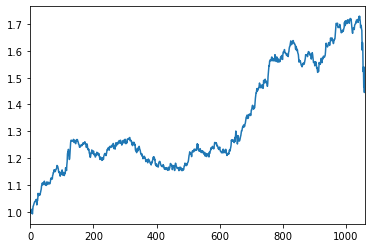

In [18]:
select = (factor_pnl[factor_pnl.columns.to_list()].mean(axis=1)+1).cumprod()
select.plot()
print(factor_pnl.columns.to_list())
print(select.iloc[-1])

In [43]:
factor_select = ['avg', 'mom', 'max52', 'K', 'D', 'J', 'trix', 'willr', 'macd', 'natr', 'mfi', 'rsi']

['avg', 'mom', 'max52', 'K', 'D', 'J', 'trix', 'willr', 'macd', 'natr', 'mfi', 'rsi']
10.547465156150178


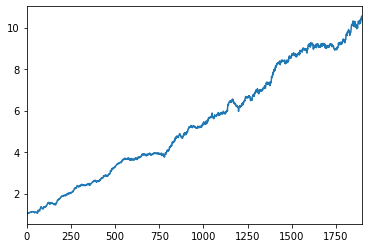

In [44]:
select = (factor_pnl[factor_select].mean(axis=1)+1).cumprod()
select.plot()
print(factor_select)
print(select.iloc[-1])

['avg', 'mom', 'max52', 'D', 'willr', 'natr', 'rsi']
21.245697255866844


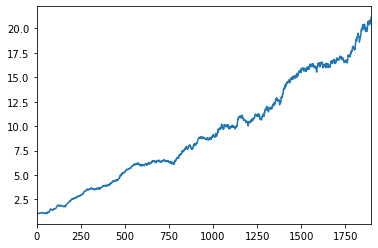

In [48]:
factor_select = ['avg', 'mom', 'max52', 'D', 'willr', 'natr', 'rsi']
select = (factor_pnl[factor_select].mean(axis=1)+1).cumprod()
select.plot()
print(factor_select)
print(select.iloc[-1])

['avg', 'mom', 'max52', 'D', 'trix', 'willr', 'natr', 'mfi', 'rsi']
14.009131010041243


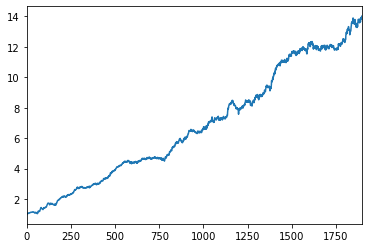

In [46]:
factor_select = ['avg', 'mom', 'max52', 'D', 'trix', 'willr', 'natr', 'mfi', 'rsi']
select = (factor_pnl[factor_select].mean(axis=1)+1).cumprod()
select.plot()
print(factor_select)
print(select.iloc[-1])

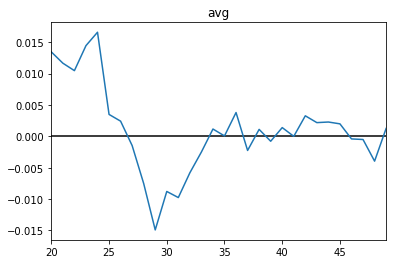

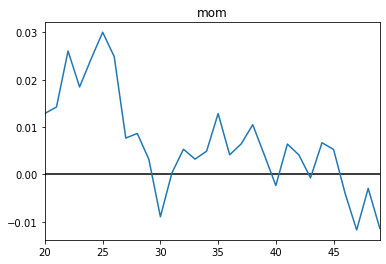

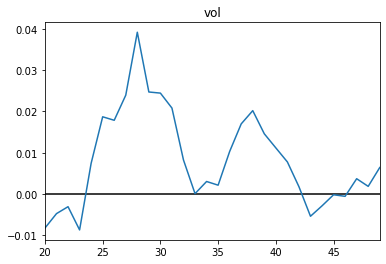

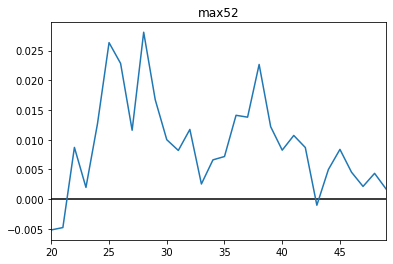

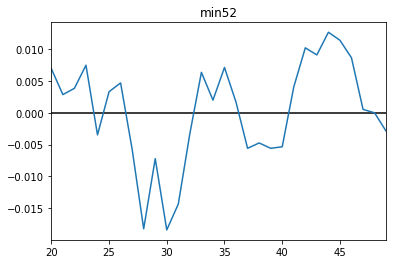

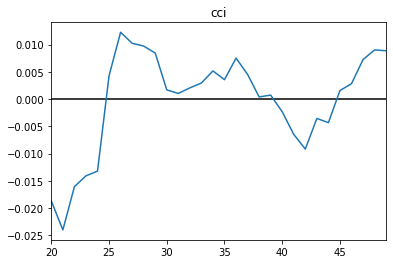

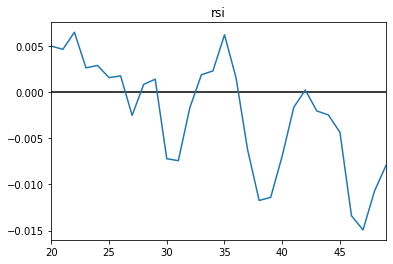

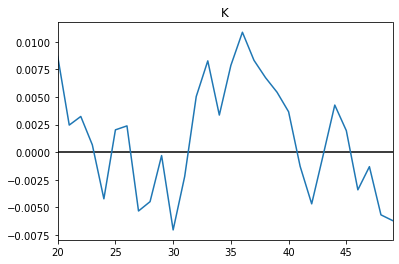

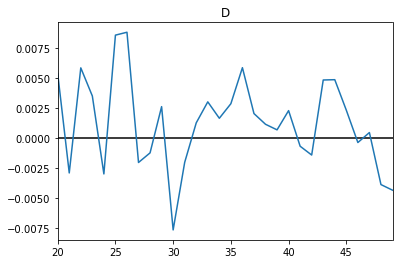

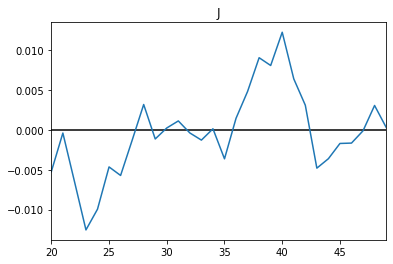

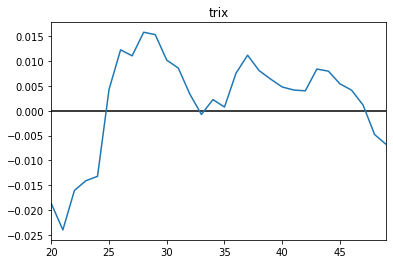

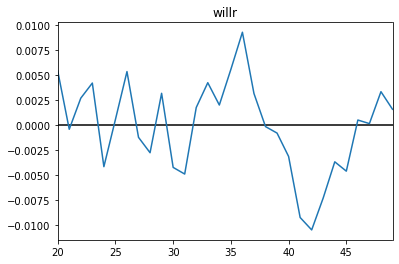

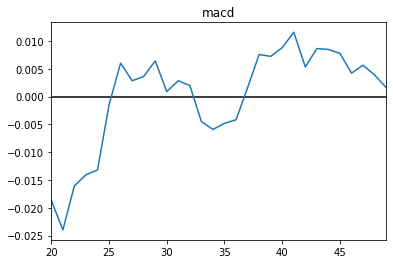

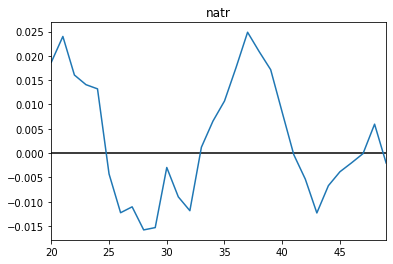

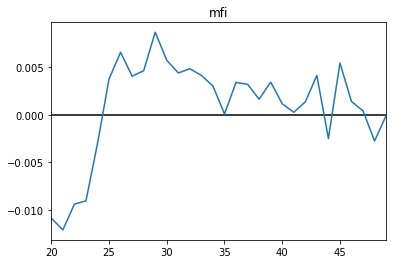

In [47]:
n = 5
for fac in factor_pnl.columns:
    (factor_pnl[fac]).rolling(n).mean()[20:50].plot(title=fac)
    plt.hlines(0,0,1100)
    plt.show()

In [19]:
factor_pnl['cci'] = get_pnl_by_factors(ccis,price,reverse=False)